In [1]:
# Import dependencies - 'display.max_columns' gets the dataframe to display all columns

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
pd.set_option('display.max_columns', None)
import folium
from folium.plugins import HeatMap
import geopandas as gpd

In [2]:
# Import file

traffic_df = pd.read_csv("Resources/sf_crash_injuries.csv", low_memory=False)

# View first 5 rows

traffic_df.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,collision_time,accident_year,month,day_of_week,time_cat,juris,officer_id,reporting_district,beat_number,primary_rd,secondary_rd,distance,direction,weather_1,weather_2,collision_severity,type_of_collision,mviw,ped_action,road_surface,road_cond_1,road_cond_2,lighting,control_device,intersection,vz_pcf_code,vz_pcf_group,vz_pcf_description,vz_pcf_link,number_killed,number_injured,street_view,dph_col_grp,dph_col_grp_description,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,analysis_neighborhood,supervisor_district,police_district,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,SF Find Neighborhoods
0,48523,26031000.0,9760000.0,190484726,37.773153,-122.437266,SFPD-INTERIM DB,CITY STREET,07/04/2019 5:50:00 PM,2019 July 04,17:50:00,2019,July,Thursday,2:01 pm to 6:00 pm,3801,179,Northern,3E11D,OAK ST,DIVISADERO ST,46.0,East,Cloudy,Not Stated,Injury (Complaint of Pain),Sideswipe,Other Motor Vehicle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,Functioning,Midblock > 20ft,Unknown,Unknown,Unknown,NaN,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,AA,Vehicle(s) Only Involved,NaN,Driver,East,Making Left Turn,Driver,East,Proceeding Straight,POINT (-122.437265708 37.773153457),07/22/2019 12:00:00 AM,04/26/2023 12:00:00 AM,01/15/2025 2:34:09 PM,Hayes Valley,5.0,PARK,4.0,11.0,9.0,26.0,26.0
1,18144,25892000.0,4987000.0,130941184,37.769376,-122.430507,SFPD-CROSSROADS,CITY STREET,11/06/2013 7:57:00 AM,2013 November 06,7:57:00,2013,November,Wednesday,6:01 am to 10:00 am,3801,30,NORTHERN,3E1A,DUBOCE AVE,BELCHER ST,75.0,West,Clear,Not Stated,Injury (Complaint of Pain),Other,Other Object,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,NaN,Midblock > 20ft,22350,22350,Unsafe speed for prevailing conditions,http://leginfo.legislature.ca.gov/faces/codes_...,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,FF,Bicycle Only,1.0,Bicyclist,East,Passing Other Vehicle,NaN,NaN,NaN,POINT (-122.430506857 37.76937557),11/06/2013 12:00:00 AM,04/26/2023 12:00:00 AM,01/15/2025 2:34:09 PM,Hayes Valley,8.0,NORTHERN,7.0,5.0,9.0,28.0,28.0
2,85951,23323000.0,7553000.0,240407262,37.717965,-122.499280,SFPD-INTERIM DB,CITY STREET,06/30/2024 3:30:00 PM,2024 June 30,15:30:00,2024,June,Sunday,2:01 pm to 6:00 pm,3801,986,Taraval,3I15D,JOHN MUIR DR,SKYLINE BLVD,465.0,East,Clear,Not Stated,Injury (Other Visible),Sideswipe,Bicycle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,NaN,Midblock > 20ft,NaN,NaN,Unknown,NaN,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,EE,Bicycle-Parked Car,NaN,Bicyclist,West,Proceeding Straight,Parked Vehicle,West,Parked,POINT (-122.499279855 37.717965025),01/15/2025 12:00:00 AM,01/15/2025 12:00:00 AM,01/15/2025 2:34:09 PM,Lakeshore,7.0,TARAVAL,10.0,8.0,16.0,43.0,43.0
3,40285,27343000.0,912101.0,3346324,37.758175,-122.476625,SFPD-CROSSROADS,CITY STREET,07/07/2007 3:53:00 AM,2007 July 07,3:53:00,2007,July,Saturday,2:01 am to 6:00 am,3801,841,TARAV,3TIE,19TH AVE,LAWTON ST,74.0,North,Clear,Not Stated,Injury (Other Visible),Sideswipe,Pedestrian,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Dark - Street Lights,Functioning,Midblock > 20ft,Unknown,Unknown,Unknown,Not Stated,0.0,2,https://maps.google.com/maps?q=&layer=c&cbll=3...,AA,Vehicle(s) Only Involved,1.0,Driver,North,Proceeding Straight,Driver,North,Proceeding Straight,POINT (-122.476624651 37.758174498),07/07/2007 12:00:00 AM,04/26/2023 12:00:00 AM,01/15/2025 2:34:09 PM,Inner Sunset,7.0,TARAVAL,10.0,8.0,14.0,44.0,44.0
4,43712,27546000.0,2671000.0,2658927,37.776248,-122.485626,SFPD-CROSSROADS,CITY STREET,05/04/2006 2:30:00 PM,2006 May 04,14:30:00,2006,May,Thursday,2:01 pm to 6:00 pm,3801,208,NaN,NaN,

In [3]:
# Display columns and datatypes

traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61272 entries, 0 to 61271
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   unique_id                     61272 non-null  int64  
 1   cnn_intrsctn_fkey             61250 non-null  float64
 2   cnn_sgmt_fkey                 27361 non-null  float64
 3   case_id_pkey                  61272 non-null  object 
 4   tb_latitude                   61104 non-null  float64
 5   tb_longitude                  61104 non-null  float64
 6   geocode_source                61272 non-null  object 
 7   geocode_location              61272 non-null  object 
 8   collision_datetime            61272 non-null  object 
 9   collision_date                61272 non-null  object 
 10  collision_time                61212 non-null  object 
 11  accident_year                 61272 non-null  int64  
 12  month                         61272 non-null  object 
 13  d

In [4]:
# Convert 'collision_datetime' from object to datetime

traffic_df['collision_datetime'] = pd.to_datetime(traffic_df['collision_datetime'])

# Convert 'collision_date ' from object to datetime
traffic_df['collision_date'] = pd.to_datetime(traffic_df['collision_date']) 

# Convert 'collision_time' from an object to datetime - A method converts 'collision_time' string into integer of total seconds then applies the changes
def to_seconds(time):    
    try:
        parts = str(time).split(':')
        seconds = int(parts[0]) * 60 * 60 + int(parts[1]) * 60 + int(parts[2])
        return seconds
    except IndexError:
        return 0
    except ValueError:
        return 0
traffic_df['collision_time_seconds'] = traffic_df['collision_time'].apply(to_seconds)

# Transform the data in new column 'collision_time_seconds' from seconds into military time
traffic_df['collision_military_time'] = pd.to_timedelta(traffic_df['collision_time_seconds'], unit='s')

# Show first 5 rows of updated dataframe
traffic_df.info()

C:\Users\docho\AppData\Local\Temp\ipykernel_27216\3567825266.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  traffic_df['collision_datetime'] = pd.to_datetime(traffic_df['collision_datetime'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61272 entries, 0 to 61271
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   unique_id                     61272 non-null  int64          
 1   cnn_intrsctn_fkey             61250 non-null  float64        
 2   cnn_sgmt_fkey                 27361 non-null  float64        
 3   case_id_pkey                  61272 non-null  object         
 4   tb_latitude                   61104 non-null  float64        
 5   tb_longitude                  61104 non-null  float64        
 6   geocode_source                61272 non-null  object         
 7   geocode_location              61272 non-null  object         
 8   collision_datetime            61272 non-null  datetime64[ns] 
 9   collision_date                61272 non-null  datetime64[ns] 
 10  collision_time                61212 non-null  object         
 11  accident_year  

# Josh: Between 2005 and 2024, what were the number of accidents over time per year?

In [5]:
traffic_df.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,collision_time,accident_year,month,day_of_week,time_cat,juris,officer_id,reporting_district,beat_number,primary_rd,secondary_rd,distance,direction,weather_1,weather_2,collision_severity,type_of_collision,mviw,ped_action,road_surface,road_cond_1,road_cond_2,lighting,control_device,intersection,vz_pcf_code,vz_pcf_group,vz_pcf_description,vz_pcf_link,number_killed,number_injured,street_view,dph_col_grp,dph_col_grp_description,party_at_fault,party1_type,party1_dir_of_travel,party1_move_pre_acc,party2_type,party2_dir_of_travel,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,analysis_neighborhood,supervisor_district,police_district,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,SF Find Neighborhoods,collision_time_seconds,collision_military_time
0,48523,26031000.0,9760000.0,190484726,37.773153,-122.437266,SFPD-INTERIM DB,CITY STREET,2019-07-04 17:50:00,2019-07-04,17:50:00,2019,July,Thursday,2:01 pm to 6:00 pm,3801,179,Northern,3E11D,OAK ST,DIVISADERO ST,46.0,East,Cloudy,Not Stated,Injury (Complaint of Pain),Sideswipe,Other Motor Vehicle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,Functioning,Midblock > 20ft,Unknown,Unknown,Unknown,NaN,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,AA,Vehicle(s) Only Involved,NaN,Driver,East,Making Left Turn,Driver,East,Proceeding Straight,POINT (-122.437265708 37.773153457),07/22/2019 12:00:00 AM,04/26/2023 12:00:00 AM,01/15/2025 2:34:09 PM,Hayes Valley,5.0,PARK,4.0,11.0,9.0,26.0,26.0,64200,0 days 17:50:00
1,18144,25892000.0,4987000.0,130941184,37.769376,-122.430507,SFPD-CROSSROADS,CITY STREET,2013-11-06 07:57:00,2013-11-06,7:57:00,2013,November,Wednesday,6:01 am to 10:00 am,3801,30,NORTHERN,3E1A,DUBOCE AVE,BELCHER ST,75.0,West,Clear,Not Stated,Injury (Complaint of Pain),Other,Other Object,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,NaN,Midblock > 20ft,22350,22350,Unsafe speed for prevailing conditions,http://leginfo.legislature.ca.gov/faces/codes_...,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,FF,Bicycle Only,1.0,Bicyclist,East,Passing Other Vehicle,NaN,NaN,NaN,POINT (-122.430506857 37.76937557),11/06/2013 12:00:00 AM,04/26/2023 12:00:00 AM,01/15/2025 2:34:09 PM,Hayes Valley,8.0,NORTHERN,7.0,5.0,9.0,28.0,28.0,28620,0 days 07:57:00
2,85951,23323000.0,7553000.0,240407262,37.717965,-122.499280,SFPD-INTERIM DB,CITY STREET,2024-06-30 15:30:00,2024-06-30,15:30:00,2024,June,Sunday,2:01 pm to 6:00 pm,3801,986,Taraval,3I15D,JOHN MUIR DR,SKYLINE BLVD,465.0,East,Clear,Not Stated,Injury (Other Visible),Sideswipe,Bicycle,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Daylight,NaN,Midblock > 20ft,NaN,NaN,Unknown,NaN,0.0,1,https://maps.google.com/maps?q=&layer=c&cbll=3...,EE,Bicycle-Parked Car,NaN,Bicyclist,West,Proceeding Straight,Parked Vehicle,West,Parked,POINT (-122.499279855 37.717965025),01/15/2025 12:00:00 AM,01/15/2025 12:00:00 AM,01/15/2025 2:34:09 PM,Lakeshore,7.0,TARAVAL,10.0,8.0,16.0,43.0,43.0,55800,0 days 15:30:00
3,40285,27343000.0,912101.0,3346324,37.758175,-122.476625,SFPD-CROSSROADS,CITY STREET,2007-07-07 03:53:00,2007-07-07,3:53:00,2007,July,Saturday,2:01 am to 6:00 am,3801,841,TARAV,3TIE,19TH AVE,LAWTON ST,74.0,North,Clear,Not Stated,Injury (Other Visible),Sideswipe,Pedestrian,No Pedestrian Involved,Dry,No Unusual Condition,Not Stated,Dark - Street Lights,Functioning,Midblock > 20ft,Unknown,Unknown,Unknown,Not Stated,0.0,2,https://maps.google.com/maps?q=&layer=c&cbll=3...,AA,Vehicle(s) Only Involved,1.0,Driver,North,Proceeding Straight,Driver,North,Proceeding Straight,POINT (-122.476624651 37.758174498),07/07/2007 12:00:00 AM,04/26/2023 12:00:00 AM,01/15/2025 2:34:09 PM,Inner Sunset,7.0,TARAVAL,10.0,8.0,14.0,44.0,44.0,13980,0 days 03:53:00
4,43712,27546000.0,2671000.0,2658927,37.776248,-122.485626,SFPD-CROSS

In [6]:
# Check for null values in 'accident_year'

null_count_year = traffic_df['accident_year'].isnull().sum()
print(null_count_year)

0


In [7]:
# Create dataframe with years and corresponding accident counts

yearly_accidents = traffic_df.groupby('accident_year').count()[['unique_id']]
yearly_accidents.head()

,unique_id
accident_year,
2005,3257
2006,2896
2007,3065
2008,3039
2009,2900


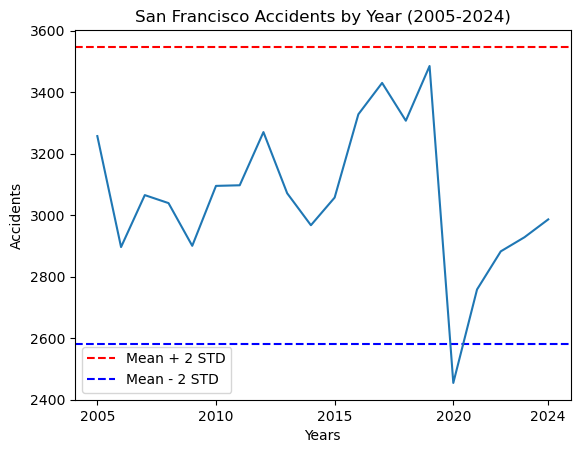

In [10]:
# Create line graph for accidents by year with 2x standard deviation bars 
mean_accidents = yearly_accidents.mean()
std_accidents = yearly_accidents.std()
plt.axhline(mean_accidents + (std_accidents * 2), color='red', linestyle='--', label='Mean + 2 STD')
plt.axhline(mean_accidents - (std_accidents * 2), color='blue', linestyle='--', label='Mean - 2 STD')

yearly_accidents = traffic_df.groupby('accident_year').size()
plt.plot(yearly_accidents)
plt.title("San Francisco Accidents by Year (2005-2024)")
plt.xlabel("Years")
plt.xticks([2005, 2010, 2015, 2020, 2024])
plt.ylabel("Accidents")
plt.legend()

plt.show()

# Tray: What is the ranked list of years by accident count? 

In [ ]:
# Create a dataframe with accident counts by year in descending order

traffic_df['Year'] = traffic_df['collision_date'].dt.year

accidents_by_year = traffic_df.groupby('Year').size().reset_index(name='Accident Count')

ranked_years = accidents_by_year.sort_values('Accident Count', ascending=False)

(ranked_years)

,Year,Accident Count
14,2019,3485
12,2017,3430
11,2016,3328
13,2018,3307
7,2012,3270
0,2005,3257
6,2011,3097
5,2010,3095
8,2013,3071
2,2007,3065


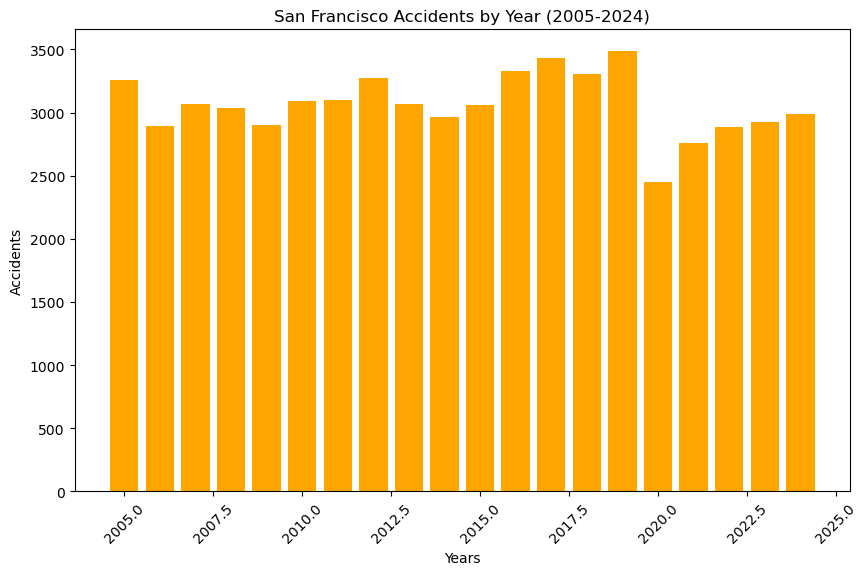

In [ ]:
# Plot the data as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(ranked_years['Year'], ranked_years['Accident Count'], color='orange')
plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('San Francisco Accidents by Year (2005-2024)')
plt.xticks(rotation=45)
plt.show()

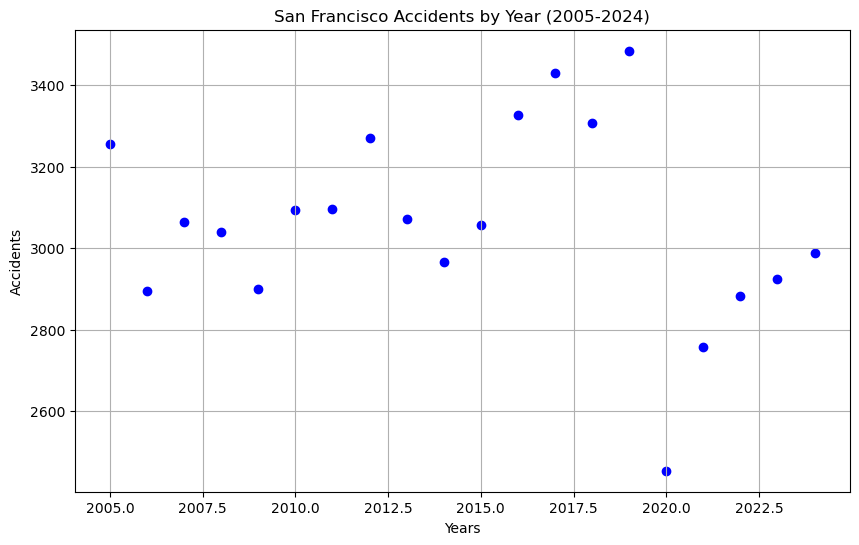

In [ ]:
# Plot the data as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ranked_years['Year'], ranked_years['Accident Count'], color='blue')
plt.xlabel('Years')
plt.ylabel('Accidents')
plt.title('San Francisco Accidents by Year (2005-2024)')
plt.grid(True)
plt.show()

# Josh: Between 2005 and 2024, which neighborhood has had the most accidents?

In [ ]:
#neighborhood_accidents = traffic_df.groupby('analysis_neighborhood').count()[['unique_id']].sort_values(by='unique_id', ascending=False)
neighborhood_accidents = (
    traffic_df.groupby('analysis_neighborhood')
    .count()[['unique_id']]
    .rename(columns={'unique_id': 'count'})  # Rename column for clarity
    .sort_values(by=['count'], ascending=False)
    .reset_index()  # Convert index to column
)
print(neighborhood_accidents)

             analysis_neighborhood  count
0                          Mission   7619
1                  South of Market   4949
2   Financial District/South Beach   4212
3                       Tenderloin   3793
4            Bayview Hunters Point   3697
5                  Sunset/Parkside   2576
6                 Western Addition   2498
7                     Hayes Valley   2192
8                    Outer Mission   1798
9               West of Twin Peaks   1721
10                Golden Gate Park   1688
11                  Outer Richmond   1656
12                        Nob Hill   1580
13             Castro/Upper Market   1519
14                       Excelsior   1450
15                  Bernal Heights   1397
16                          Marina   1353
17                 Pacific Heights   1216
18                    Russian Hill   1136
19                  Inner Richmond   1103
20                       Lakeshore   1083
21                     Mission Bay   1071
22                    Inner Sunset

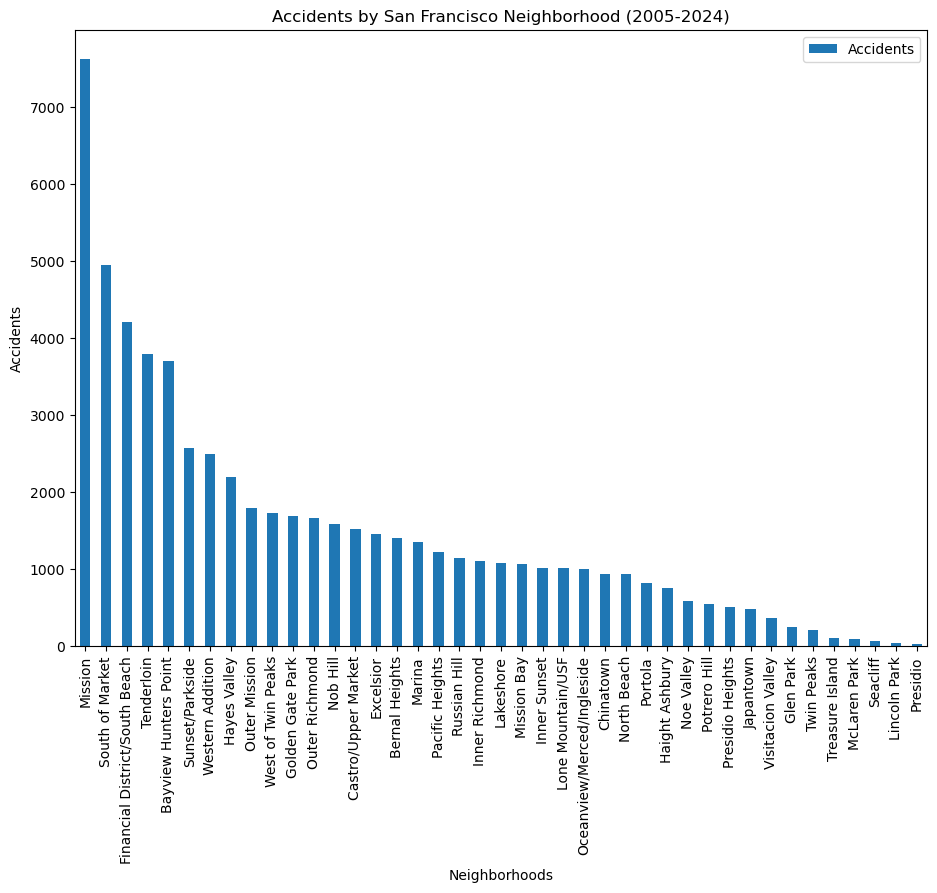

In [ ]:
# Create a bar chart of accident counts by neighborhood
neighborhood_accidents.plot(
    kind='bar',
    legend=False,
    x='analysis_neighborhood',
    y='count',
    xlabel='Neighborhoods',
    ylabel='Accidents',
    figsize=(11, 8)
)

# Add a custom legend
plt.legend(['Accidents'])

# Optional title
plt.title("Accidents by San Francisco Neighborhood (2005-2024)")
plt.show()

In [ ]:
# Create a heatmap of accident counts by neighborhoods overlaid on a map of SF

# Pull a shapefile of SF neighborhoods from Kaggle here: https://www.kaggle.com/datasets/broach/san-francisco-neighborhood-maps/data

# Load the shapefile
traffic_shape = gpd.read_file('Resources/sf_shapefile/planning_neighborhoods.shp')

traffic_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   neighborho  37 non-null     object  
 1   geometry    37 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 720.0+ bytes


In [ ]:
# Create the base map centered around San Francisco, 
sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12, tiles="OpenStreetMap")

# Plot neighborhoods on the map (Adds neighborhood boundaries on top of the base map)
folium.GeoJson(traffic_shape).add_to(sf_map)

# Get the accident data and create a heatmap based on latitude (tb_latitude) and longitude (tb_longitude), ignore any empty cells
accidents = traffic_df[['tb_latitude', 'tb_longitude']].dropna()

# Add heatmap data based on latitude and longitude
heat_data = [[row['tb_latitude'], row['tb_longitude']] for index, row in accidents.iterrows()]

# Add the heatmap to the map
HeatMap(
    data=heat_data,
    radius=3,
    blur=1,
    min_opacity=0.7,
    max_zoom=55).add_to(sf_map)

# Show the map (uses folium's built-in display functionality)
sf_map

# Tray: Between 2005-2024, which police district had the most accidents?

In [ ]:
# Create a table of accidents by police district in descending order
traffic_df = traffic_df[traffic_df['collision_date'].dt.year >= 2005]
accidents_by_district = traffic_df.groupby('police_district').size().reset_index(name='Accident Count')
ranked_districts = accidents_by_district.sort_values('Accident Count', ascending=False)

print(ranked_districts)

  police_district  Accident Count
7        SOUTHERN            9866
4        NORTHERN            9196
3         MISSION            8364
8         TARAVAL            6737
2       INGLESIDE            5712
0         BAYVIEW            5549
6        RICHMOND            5195
1         CENTRAL            5043
5            PARK            3637
9      TENDERLOIN            1719


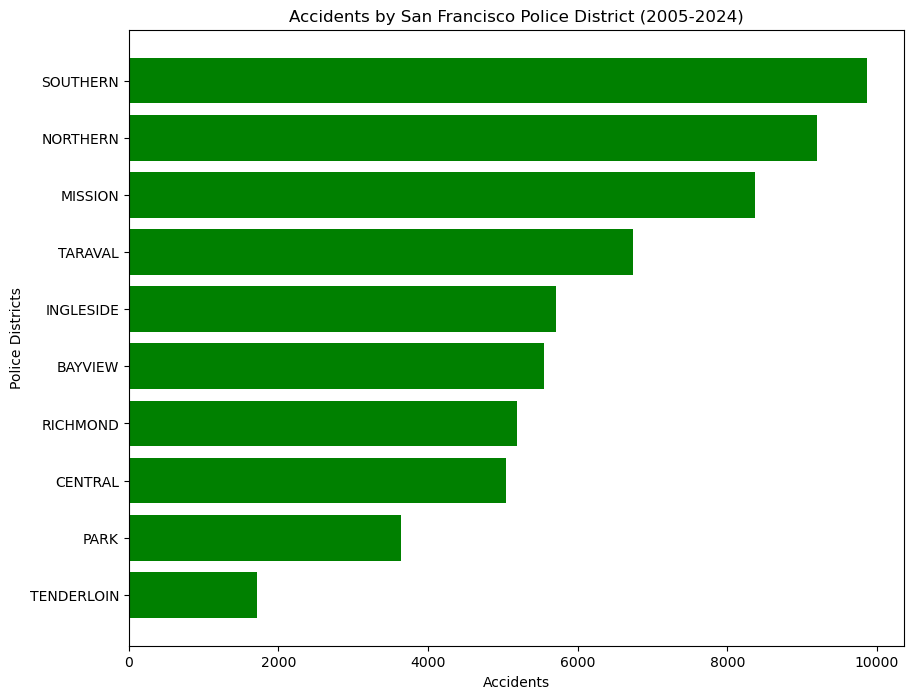

In [ ]:
# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(ranked_districts['police_district'], ranked_districts['Accident Count'], color='green')

# Labels and title
plt.xlabel('Accidents')
plt.ylabel('Police Districts')
plt.title('Accidents by San Francisco Police District (2005-2024)')

# Invert y-axis 
plt.gca().invert_yaxis()


plt.show()

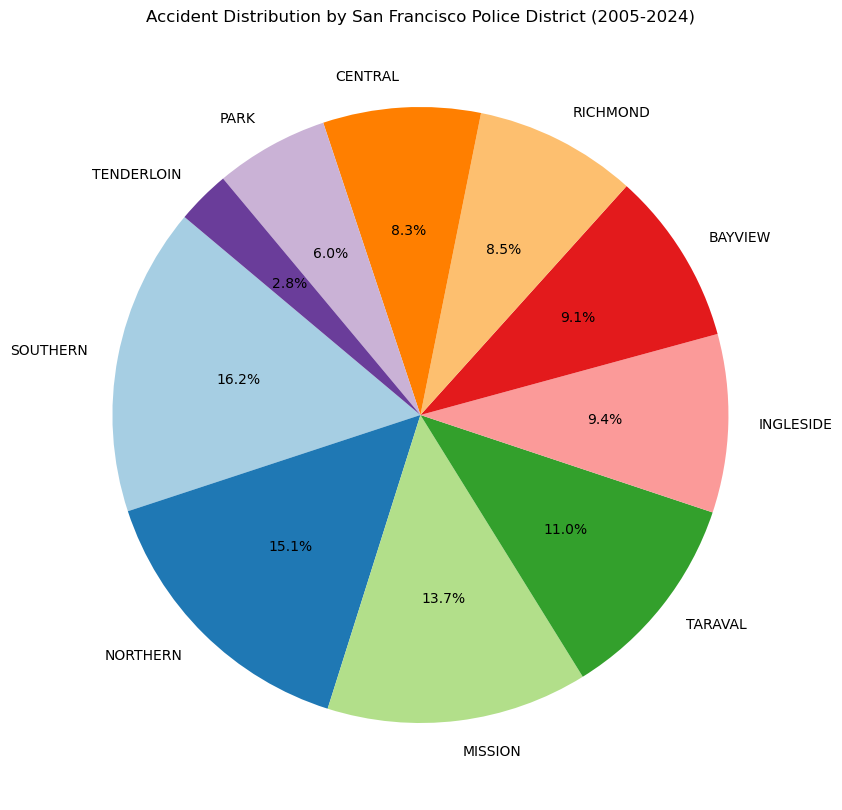

In [ ]:
# Create a pie chart
plt.figure(figsize=(10, 10))
plt.pie(ranked_districts['Accident Count'], labels=ranked_districts['police_district'], 
        autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140)


plt.title('Accident Distribution by San Francisco Police District (2005-2024)')

plt.show()

# Josh: Is there a month that has more accidents than others?

In [ ]:
# Check to see if there are any null values in the collision_date column

monthly_collisions_null = traffic_df['collision_date'].isnull().sum()
print(monthly_collisions_null)

0


In [ ]:
# Create a table of accident counts by month in descending order

# Extract the month from 'collision_date'
traffic_df['month'] = traffic_df['collision_date'].dt.month

# Count the total accidents for each month across all years
monthly_collisions_count = traffic_df.groupby('month').size()

# Reset index to present the DataFrame with the count of accidents
monthly_collisions_count_reset = monthly_collisions_count.reset_index(name='accident_count').sort_values(by='accident_count', ascending=False).reset_index(drop=True)

# Print the result
print(monthly_collisions_count_reset)

    month  accident_count
0      10            5884
1       9            5499
2       8            5202
3       3            5183
4      12            5051
5      11            5037
6       5            4989
7       6            4938
8       4            4924
9       7            4878
10      1            4874
11      2            4813


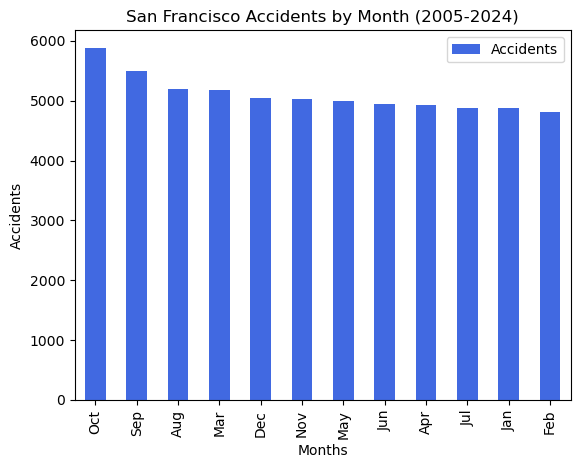

In [ ]:
# Create a bar chart of accidents by month, format the x-axis so that months correctly display with associated counts
# Dictionary to map month numbers to names
month_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Convert numerical months to names
monthly_collisions_count_reset['month'] = monthly_collisions_count_reset['month'].map(month_mapping)

monthly_collisions_count_reset.plot(
    kind='bar',
    legend=False,
    x='month',
    y='accident_count',
    xlabel='Months',
    ylabel='Accidents',
    color='royalblue'
)

# Legend
plt.legend(['Accidents'])

# Figure title
plt.title("San Francisco Accidents by Month (2005-2024)")

#Display
plt.show()

# Tsedenia: What day of the week has the most accidents and fatalities?

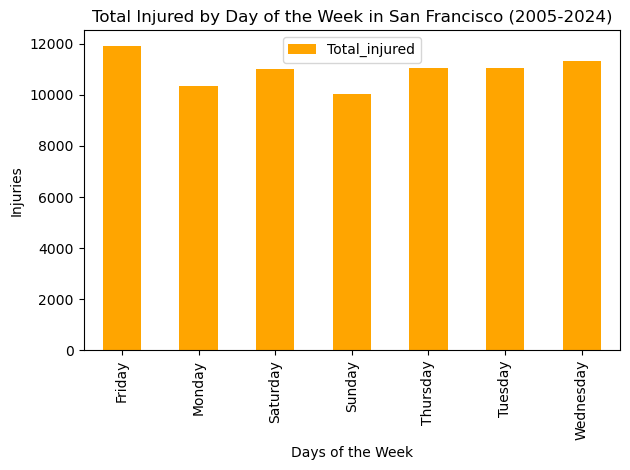

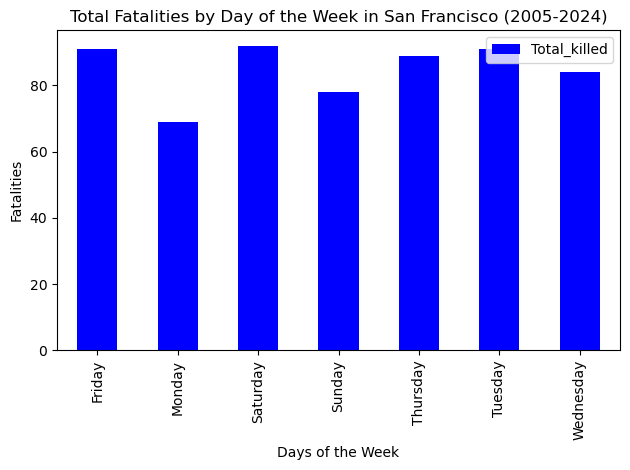

In [ ]:
# Create bar charts for accidents and fatalities by day of the week from 2005-2024
traffic_df_dayofweekinj= traffic_df.groupby(['day_of_week'])['number_injured'].agg(Total_injured=("sum"))
traffic_df_dayofweekinj

traffic_df_dayofweekinj.plot(kind='bar', y='Total_injured', title ='Total Injured by Day of the Week in San Francisco (2005-2024)', color = 'orange')
 
plt.ylabel('Injuries')
plt.xlabel('Days of the Week')
plt.tight_layout()
plt.show()

traffic_df_dayofweekkilled= traffic_df.groupby(['day_of_week'])['number_killed'].agg(Total_killed=("sum"))
traffic_df_dayofweekkilled
# Custom colors
colors = ['red', 'blue', 'green', 'orange']


traffic_df_dayofweekkilled.plot(kind='bar', y='Total_killed', title ='Total Fatalities by Day of the Week in San Francisco (2005-2024)', color='blue')
 
plt.ylabel('Fatalities')
plt.xlabel('Days of the Week')
plt.tight_layout()
plt.show()



# Tsedenia: What weather type is most associated with accidents between 2005-2024?


In [ ]:
# Filter the DataFrame for accidents with at least one fatality or injury
traffic_df_accidentbyweather = traffic_df[
    (traffic_df['number_killed'] > 0) | (traffic_df['number_injured'] > 0)
].groupby(['weather_1'])[['number_killed', 'number_injured']].agg(
    Total_killed=('number_killed', 'sum'),
    Total_injured=('number_injured', 'sum')
)

# Display the resulting dataframe
traffic_df_accidentbyweather

,Total_killed,Total_injured
weather_1,,
Clear,469.0,63369
Cloudy,68.0,7580
Fog,5.0,328
Fog / Visibility,0.0,1
Fog / Visibility: 10 ft,0.0,1
Fog / Visibility: 800 ft,0.0,1
Not Stated,17.0,775
Other,4.0,266
Other: MISTING,0.0,1


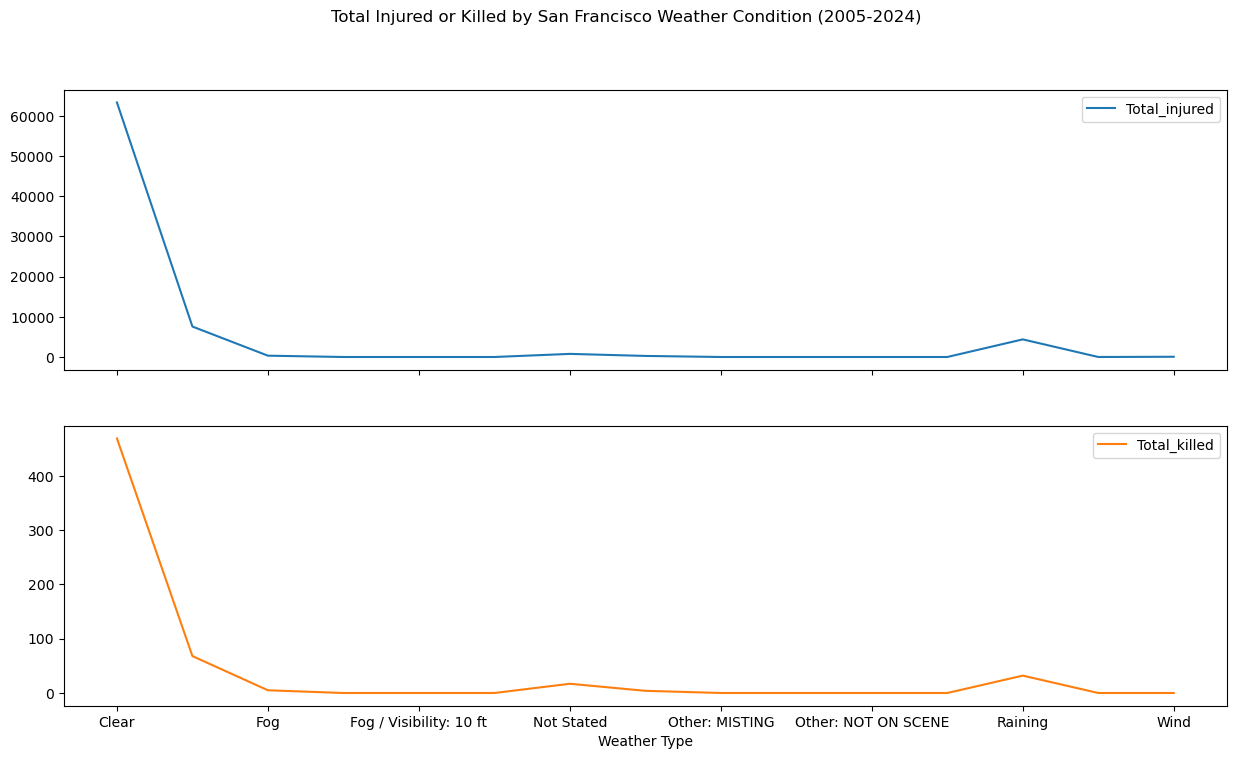

In [ ]:
# Create a line chart displaying the total injury and fatality counts by weather condition
traffic_df_accidentbyweather = traffic_df[
    (traffic_df['number_killed'] > 0) | (traffic_df['number_injured'] > 0)
].groupby(['weather_1'])[['number_injured', 'number_killed']].agg(
    Total_injured=('number_injured', 'sum'),
    Total_killed=('number_killed', 'sum'),
)

# Display the result
traffic_df_accidentbyweather.plot(subplots=True,figsize=(15, 8),title='Total Injured or Killed by San Francisco Weather Condition (2005-2024)')
plt.xlabel('Weather Type')
plt.show()

# Tray: What were the top 3 collision types by year?

In [ ]:
# Calculate the top 3 collision types between 2005-2024 (denom = all)


traffic_df = traffic_df[traffic_df['collision_date'].dt.year >= 2005]
collision_counts = traffic_df['type_of_collision'].value_counts()


total_accidents = traffic_df.shape[0]
top_3_collisions = collision_counts.head(3)
top_3_percentages = (top_3_collisions / total_accidents) * 100

("Top 3 Collision Types and their Percentages:")
(top_3_percentages)

type_of_collision
Broadside             30.589829
Vehicle/Pedestrian    20.934521
Rear End              16.234169
Name: count, dtype: float64

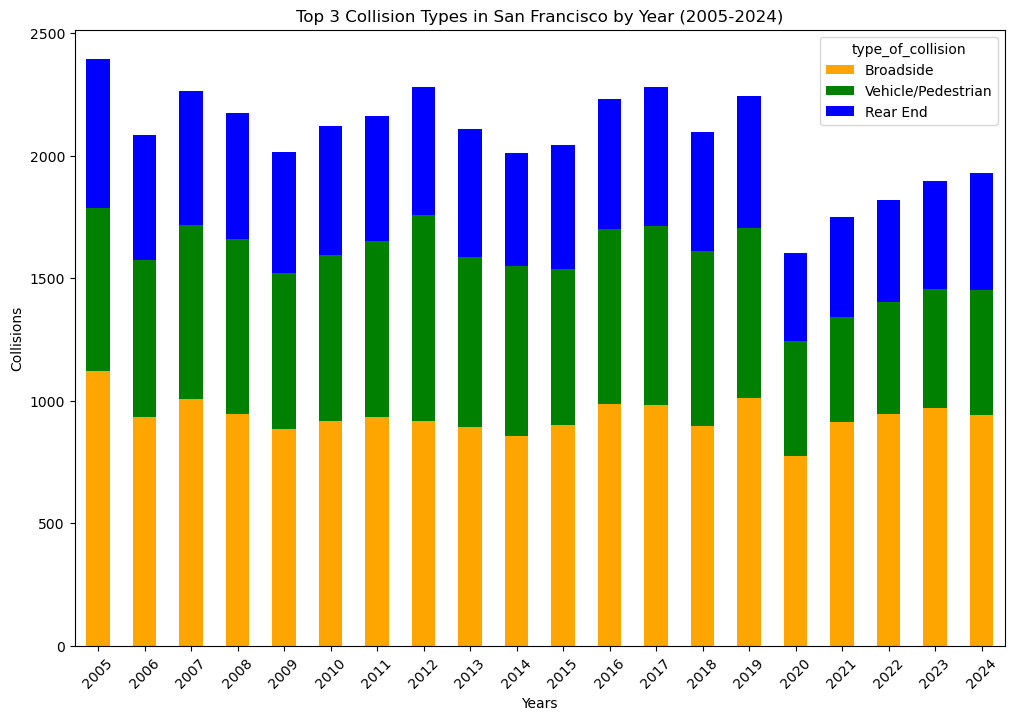

In [ ]:
# Create stacked bar chart of top 3 collision types by year
collision_by_year = traffic_df.groupby([traffic_df['collision_date'].dt.year, 'type_of_collision']).size().unstack()

# Plot the stacked bar plot
collision_by_year[top_3_collisions.index].plot(kind='bar', stacked=True, figsize=(12, 8), color=['orange', 'green', 'blue'])
plt.title('Top 3 Collision Types in San Francisco by Year (2005-2024)')
plt.xlabel('Years')
plt.ylabel('Collisions')
plt.xticks(rotation=45)
plt.show()

# Tsedenia: What percentage of injury crashes between 2005-2024 resulted in at least one fatality?

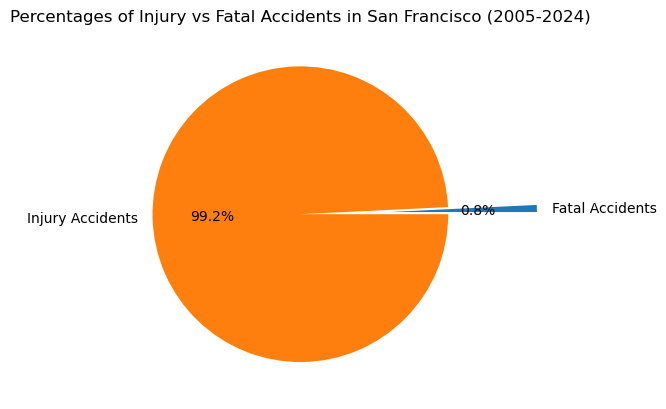

In [ ]:
#Calculation: (Number of crashes with fatalities) / (Number of injury crashes) = Proportion of injury crashes resulting in a fatality.

#Convert to percentage: Multiply the result by 100 to express it as a percentage:
total_killed = traffic_df[traffic_df['number_killed'] > 0].agg(Total_killed=('number_killed', 'sum')).values[0][0]

#Calculate the total fatalities
total_injured = traffic_df[traffic_df['number_injured'] > 0].agg(Total_Injured=('number_injured', 'sum')).values[0][0]

#Generate a pie chart of percentage of accidents with injuries vs accidents in which at least one fatality
lables = ['Fatal Accidents', 'Injury Accidents']
sizes = [total_killed,total_injured]
explode = [0.6,0]
plt.pie(sizes,labels=lables,autopct='%1.1f%%',explode=explode)
plt.title("Percentages of Injury vs Fatal Accidents in San Francisco (2005-2024)")
plt.show()